In [43]:
from __future__ import annotations
import ete3
from dataclasses import dataclass, field
import numpy as np
from matplotlib import pyplot as plt

In [185]:
# t = ete3.parser.newick.read_newick('/home/adam/Workspace/Python/OverProt/data/GuidedClustering/1.10.10.1020/cif_cealign/guide_tree.newick', format=1)
t = ete3.parser.newick.read_newick('/home/adam/Workspace/Python/OverProt/data/GuidedClustering/cyp_100/cif_cealign/guide_tree.newick', format=1)
# t = ete3.parser.newick.read_newick('/home/adam/Workspace/Python/OverProt/data/GuidedClustering/cyp_250a/cif_cealign/guide_tree.newick', format=1)
# t = ete3.parser.newick.read_newick('/home/adam/Workspace/Python/OverProt/data/GuidedClustering/cyp_all_pdb/cif_cealign/guide_tree.newick', format=1)

while len(t.children) == 1:
    t = t.children[0]
# t.dist=0.0

In [212]:
def prt(tree: ete3.coretype.tree.TreeNode, indent=0, mute=True) -> None:
    mute = mute and len(tree.children) in [0, 2]
    if not mute:
        print('    '*indent, tree.dist,':', tree.name)
    for c in tree.children:
        prt(c, indent=indent+1, mute=mute)
    # else:
        # print('    '*(indent+1), '.')

@dataclass
class Arrays(object):
    x: list[float] = field(default_factory=list)
    y: list[float] = field(default_factory=list)
    w: list[float] = field(default_factory=list)
    name: list[str] = field(default_factory=list)

def make_arrays(tree: ete3.coretype.tree.TreeNode) -> tuple[Arrays, list[tuple[int,int]]]:
    arrays = Arrays()
    edges: list[tuple[int,int]] = []
    def _make_arrays(tree: ete3.coretype.tree.TreeNode, currx: float, curry: float) -> None:
        y = curry+tree.dist
        if len(tree.children) == 0:
            arrays.x.append(currx)
            arrays.y.append(y)
            arrays.w.append(1.0)
            arrays.name.append(tree.name)
        elif len(tree.children) == 2:
            _make_arrays(tree.children[0], currx=currx, curry=y)
            i1 = len(arrays.x)-1
            x1 = arrays.x[-1]
            y1 = arrays.y[-1]
            w1 = arrays.w[-1]
            _make_arrays(tree.children[1], currx=currx+w1, curry=y)
            i2 = len(arrays.x)-1
            x2 = arrays.x[-1]
            y2 = arrays.y[-1]
            w2 = arrays.w[-1]
            w = w1 + w2 
            dy1 = y1-y
            dy2 = y2-y
            x = (x1*dy1 + x2*dy2) / (dy1 + dy2)
            arrays.x.append(x)
            arrays.y.append(y)
            arrays.w.append(w)
            arrays.name.append(tree.name)
            i = len(arrays.x)-1
            edges.append((i, i1))
            edges.append((i, i2))
        else:
            raise AssertionError(tree.children)
    _make_arrays(tree, currx=0.0, curry=0.0)
    n = len(arrays.x)
    n_leaves = int(arrays.w[-1])
    assert n == 2*n_leaves - 1
    return arrays, edges

def plttree(x, y, edges, plt=plt, equal=False, names=None):
    plt.plot(x, y, 'yo')
    for u, v in edges:
        # print(u, v)
        plt.plot([x[u], x[v]], [y[u], y[v]])
    if names is not None:
        for name, xx, yy in zip(names, x, y):
            plt.annotate(name, (xx, yy))
    if equal:
        plt.axis('equal')


100.0


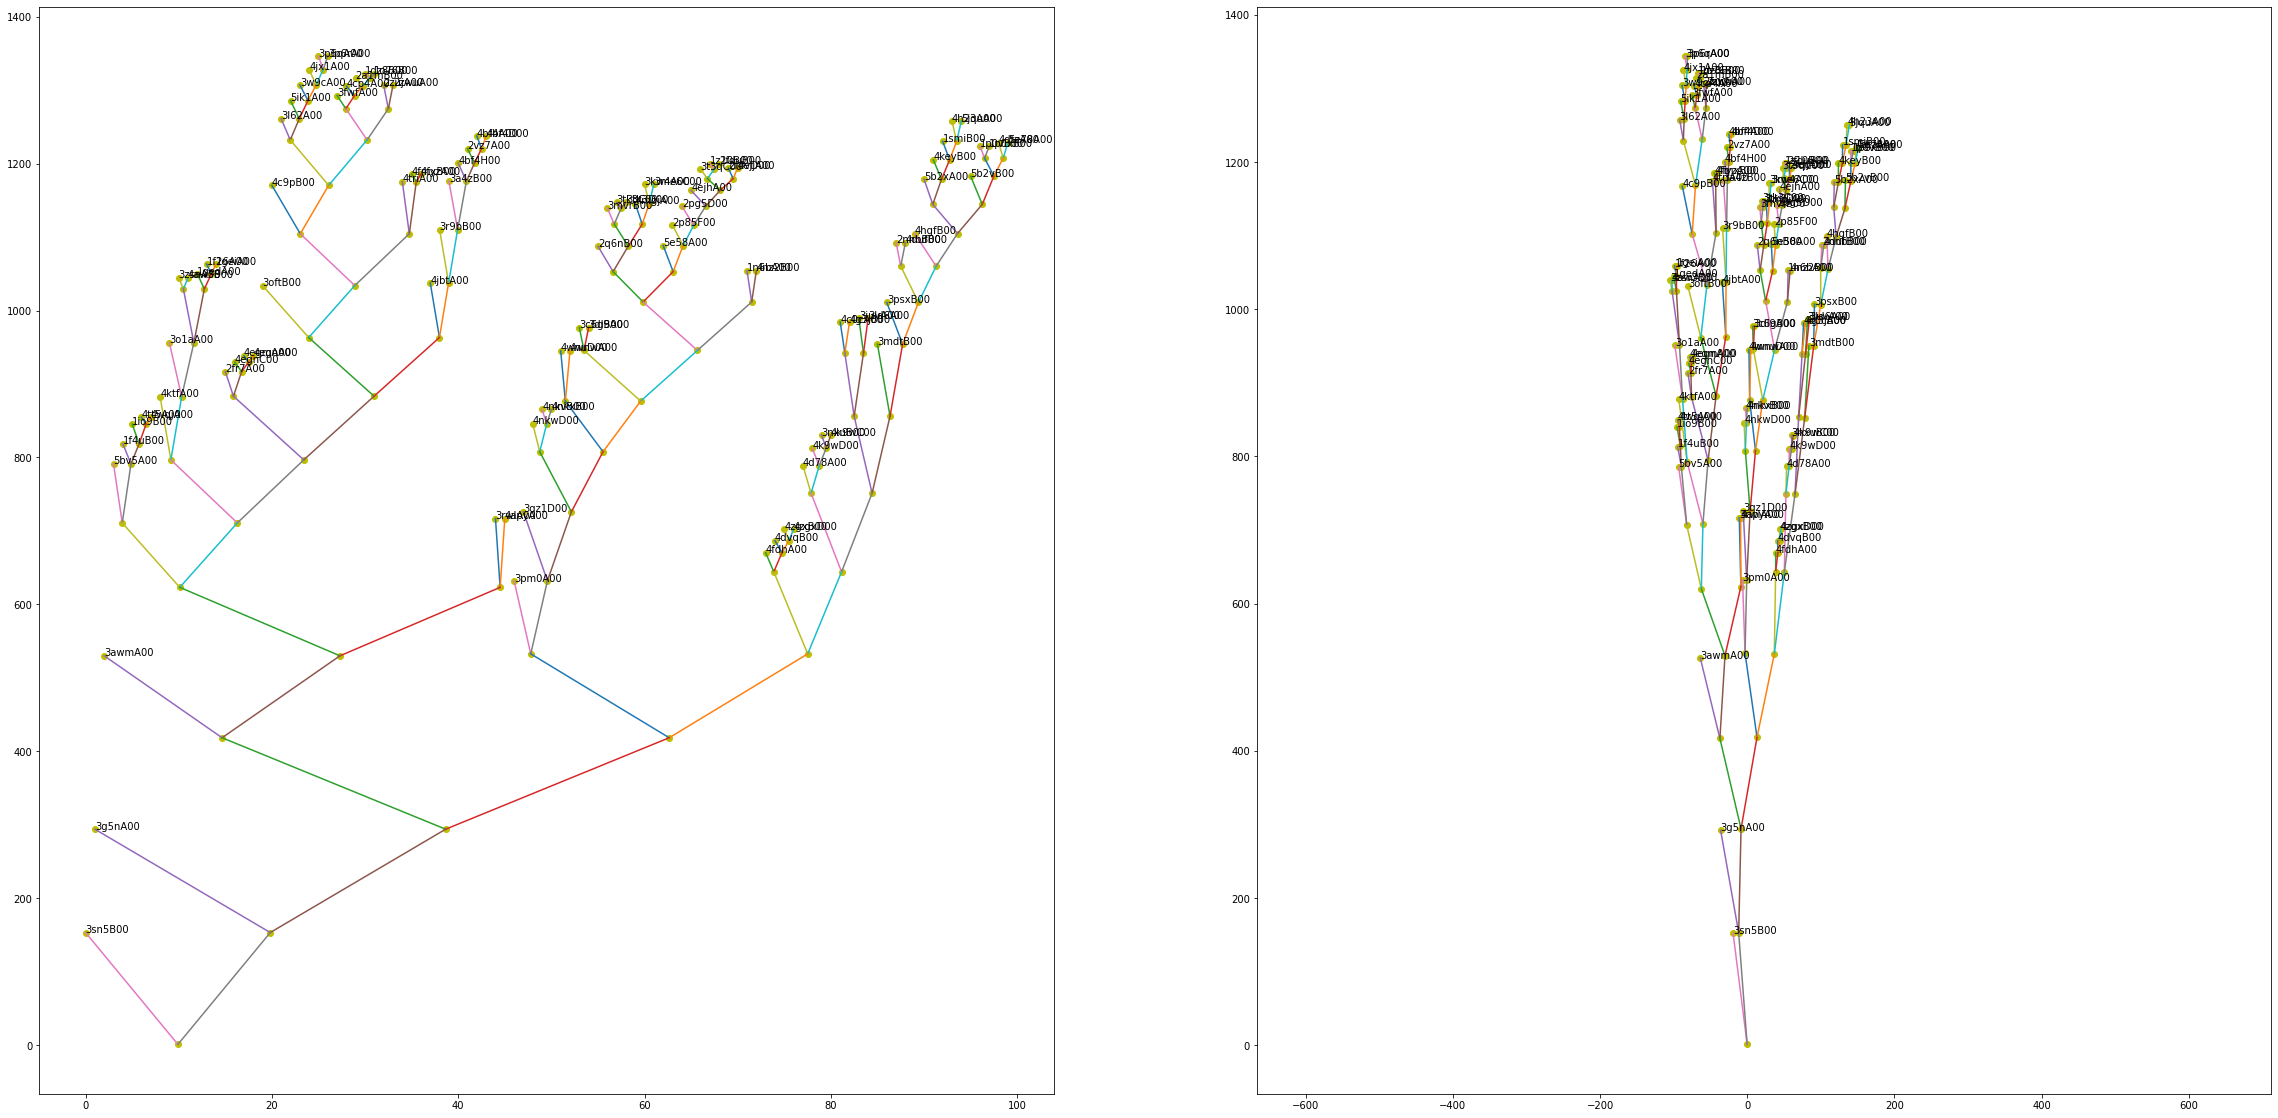

In [213]:
fig = plt.figure(figsize=(40, 20))
sub1, sub2 = fig.subplots(1,2)
# (1,2,0,figsize=(10, 10))
arrays, edges = make_arrays(t)
x = np.array(arrays.x)
y = np.array(arrays.y)
r = y
w = arrays.w[-1]
w0 = max(w, 2500)
phi = (x - w/2) / w0 * 2*np.pi
plttree(x, y, edges, plt=sub1, names=arrays.name)
# x = r * np.cos(phi)
# y = r * np.sin(phi)
x = r * np.sin(phi)
y = r * np.cos(phi)
plttree(x, y, edges, plt=sub2, equal=True, names=arrays.name)
print(arrays.w[-1])